# MTH 373 - Homework #1

**Name:** <font color="red">**_Hai T. Nguyen_**</font>

**Due:** Monday, April 15, 2024 (submit on Canvas before 11:30 am)

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

### 1. Convert from COO to CSR format (5 points)

Complete the function `load_as_csr` below. Given a filename as a string, load the matrix from the file and return the `I`, `J`, and `V` arrays corresponding to the CSR format.

Each line of the file contains three whitespace-separated values. The first row contains `m`, `n`, `nnz`. Each subsequent row corresponds to one nonzero of the matrix: `i`, `j`, and the nonzero value `v`.

Code is provided to read $m$, $n$, $nnz$, and an array `data` of length `nnz`. The `data` array is such that for each nonzero `k`, `data[k] == (i, j, v)`, where $(i,j)$ are the coordinates of the nonzero, and $v$ is the value.

The algorithm for computing to CSR is as follows.

* Allocate arrays $I$ (integers, length $m+1$), $J$ (integers, length $nnz$, and $V$ (floating point, length $nnz$)
* Initialize every entry of $I$ to zero
* Loop over the nonzeros:
    * For the $k$th nonzero $(i,j,v)$, set $I[i + 1] \gets I[i + 1] + 1$
* After this loop, $I[i + 1]$ contains the number of nonzeros in row $i$
* Compute the partial sums
* For $i = 0, 1, \ldots, m - 1$
    * $I[i + 1] \gets I[i + 1] + I[i]$
* Now $I$ is correctly set up
* Loop over every nonzero
    * Given nonzero $(i, j, v)$
    * Set $idx \gets I[i]$
    * Increment $I[i] \gets I[i] + 1$
    * $J[idx] \gets j$
    * $V[idx] \gets v$
* Reset the $I$ array after our modifications above
* For $i = m-1, m-2, \ldots 0$
    * _Note, you can use `for i in reversed(range(m)):` for this loop_
    * $I[i+1] \gets I[i]$
* $I[0] \gets 0 $

In [2]:
def load_as_csr(filename):
    # Read m, n, and nnz from the file
    m, n, nnz = np.genfromtxt(filename, max_rows=1, dtype=None)
    # Read the data as a list of tuples [(i,j,v), ...]
    data = np.genfromtxt(filename, skip_header=1, dtype=None)
    # Allocate arrays
    I = np.zeros(m + 1, dtype=int)
    J = np.zeros(nnz, dtype=int)
    V = np.zeros(nnz)
    # [Convert to CSR here...]
    # Initialize every entry of I to zero
    for i in range(nnz):
        I[data[i][0]+1] += 1
    # Compute the partial sums
    for i in range(m-1):
        I[i+1] = I[i+1] + I[i]
    # Loop over every nonzero
    for k in range(nnz):
        i, j, v = data[k]
        idx = I[i]
        J[idx] = j
        V[idx] = v
        I[i] += 1
    # Reset the I array after modifications
    for i in reversed(range(m)):
        I[i + 1] = I[i]
    I[0] = 0
    return I, J, V

You can use the function `check_matrix` to check your results.

In [3]:
def check_matrix(filename):
    A = load_as_csr(filename)
    A1 = sp.csr_matrix((A[2], A[1], A[0]))
    data = np.genfromtxt(filename, skip_header=1)
    A2 = sp.csr_matrix((data[:,2], (data[:,0].astype(int), data[:,1].astype(int))))
    if sp.linalg.norm(A1 - A2) < 1e-10:
        print("OK")
    else:
        print("Incorrect")

In [4]:
check_matrix ("64.txt")

OK


### 2. Matrix-vector product

Write a function `matvec` that takes a matrix $A$ in CSR format (as a tuple `(I, J, V)`) and a vector $v$, and returns the matrix-vector product $w = Av$.

In [5]:
def matvec(A, v):
    I, J, V = A
    m = len(I) - 1
    w = np.zeros(m)
    # [Compute w = Av here...]
    for i in range (m):
        w[i] = 0
        begin_j = I[i]
        end_j = I[i+1]
        for idx_j in range (begin_j,end_j):
            j = J[idx_j]
            w[i] = w[i] + V[idx_j]*v[j]
    return w

### 3. Run your code and check the results

Write a loop to run your code for the files `16.txt`, `25.txt`, `50.txt`, and `64.txt`.

Write a function `num_rows` that returns the number of rows of a matrix $A$ given as a tuple $(I, J, V)$. We will assume that the matrix is square, so this is also equal to the number of columns.

For each file, load the matrix, and compute the matrix-vector product with a random vector using the function `random_vector` below.

Print the error using the `check_results` function. Pass the filename and your computed vector $w$ to `check_results`. It will return the error of your computation (which should be close to zero).

In [6]:
def random_vector(m):
    """
    Returns a random vector with seed 0 (the entries are always drawn from
    the same sequence so the results are reproducible).
    """
    return np.random.default_rng(0).random(m)

In [7]:
def check_results(filename, w):
    data = np.genfromtxt(filename, skip_header=1)
    AA = sp.csr_matrix((data[:,2], (data[:,0].astype(int), data[:,1].astype(int))))
    v = random_vector(AA.shape[1])
    ww = AA @ v
    return np.linalg.norm(w - ww)

In [8]:
def num_rows(A):
    # Return the number of rows in A
    I = A[0]
    return len(I) - 1

In [9]:
for filename in ["16.txt", "25.txt", "50.txt", "64.txt"]:
    A = load_as_csr(filename)
    # Compute matrix-vector product
    v = random_vector(num_rows(A))
    w = matvec(A,v)
    # Check results
    error = check_results(filename, w)
    print(f"Error for {filename}: {error}")

Error for 16.txt: 3.645607954817335e-15
Error for 25.txt: 0.0
Error for 50.txt: 0.0
Error for 64.txt: 2.177044096967847e-15


### 4. Visualize sparsity pattern and compute memory savings

Use the function `visualize_sparsity` below to plot the sparsity pattern for each matrix (represented in CSR format as a tuple).

Given a CSR matrix, write a function `memory_usage` that estimates the memory usage. Count each integer and floating point number as one "unit" of memory.

Write a function `dense_memory_usage` that estimates the memory usage of a dense matrix of the same dimensions (you can assume the matrix is square, and use `num_columns` above to get the size).

For each of the test matrices, estimate the memory savings using CSR format compared with dense format. Justify your answer.

In [10]:
def visualize_sparsity(A):
    AA = sp.csr_matrix((A[2], A[1], A[0]))
    plt.spy(AA)

In [11]:
def memory_usage(A):
    # Return memory usage of A in CSR format
        return 2*nnz+m+1
def dense_memory_usage(A):
    # Return memory required to store A in dense format
        return m*n

Memory savings using CSR format for 16.txt: 64.45%
Memory savings using CSR format for 25.txt: 55.04%
Memory savings using CSR format for 50.txt: 50.68%
Memory savings using CSR format for 64.txt: 19.46%


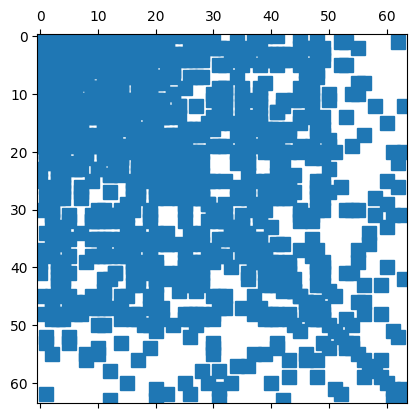

In [12]:
for filename in ["16.txt", "25.txt", "50.txt", "64.txt"]:
    A = load_as_csr(filename)
    m, n, nnz = np.genfromtxt(filename, max_rows=1, dtype=None)
    visualize_sparsity(A)
    print(f"Memory savings using CSR format for {filename}: {(memory_usage(A) / dense_memory_usage(A)) * 100:.2f}%")